In [2]:
import os
os.getcwd()
os.chdir("../")
os.getcwd()

'c:\\Users\\Marina\\Desktop\\ML Operations\\0 - KrishNaik Course\\18 - Getting Started With Your First End To End Data Science Project With\\my_project'

In [4]:
from dotenv import load_dotenv
load_dotenv()

os.environ["MLFLOW_TRACKING_URI"] = os.getenv("MLFLOW_TRACKING_URI")
os.environ["MLFLOW_TRACKING_USERNAME"] = os.getenv("MLFLOW_TRACKING_USERNAME")
os.environ["MLFLOW_TRACKING_PASSWORD"] = os.getenv("MLFLOW_TRACKING_PASSWORD")

## Creating the Dataclass

**Todos os elementos do config.yaml devem estar nesta classe**

In [5]:
from dataclasses import dataclass
from pathlib import Path
import json

# from yaml
# model_evaluation:
#   root_dir: artifacts/model_evaluation
#   X_test_data_path: artifacts/data_transformation/X_test.csv
#   y_test_data_path: artifacts/data_transformation/y_test.csv
#   model_path: artifacts/model_trainer/model.joblib
#   metric_file_name: artifacts/model_evaluation/metrics.json

@dataclass
class ModelEvaluationConfig():
  # config.yaml
  root_dir: Path
  X_test_data_path: Path
  y_test_data_path: Path
  model_path: Path
  metric_file_name: Path

  #params.yaml
  all_params: dict

  #mlflow_uri: str

## Update the Config Manager

In [16]:
from src.datascience.constants import CONFIG_FILEPATH, PARAMS_FILEPATH, SCHEMA_FILEPATH
from src.datascience.utils.commons import read_yaml, create_directories, save_json

class ConfigurationManager():
    def __init__(self, # recebe os parâmetros que seram usados para instanciar as propriedades p/leitura
                 config_filepath = CONFIG_FILEPATH,
                 params_filepath = PARAMS_FILEPATH,
                 schema_filepath = SCHEMA_FILEPATH,):
        
        # instância as propriedades com base nas leituras dos parâmetros passados acima
        self.config = read_yaml(config_filepath) # lê as configurações
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root]) # cria o /artifacts

    def get_model_evaluation_config(self) -> ModelEvaluationConfig:
        
        config = self.config.model_evaluation # change the "section" of the config file
        params = self.params.ElasticNet # change the "section" of the config file


        create_directories([config.root_dir]) # cria o /artifacts/model_evaluation

        model_evaluation_config = ModelEvaluationConfig(
            # config.yaml
            root_dir= config.root_dir,
            X_test_data_path= config.X_test_data_path, 
            y_test_data_path= config.y_test_data_path,
            model_path= config.model_path,
            metric_file_name= config.metric_file_name,

            #params.yaml
            all_params= params,
            )
        
        return model_evaluation_config

## Update the Components

In [ ]:
import urllib.parse as urlparse
import pandas as pd
from src.datascience.utils import logger
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.base import RegressorMixin
from sklearn.linear_model import ElasticNet
import joblib
import mlflow
import mlflow.sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
                            # is being marked as decrapted, but it is not.

class ModelEvaluation:
    def __init__(self, config: ModelEvaluationConfig):
        # config should be an instance of DataTransformationConfig(the output of the previous cell)
        self.config = config

        # model_evaluation_config = ModelEvaluationConfig(
        #     # config.yaml
        #     root_dir= config.root_dir,
        #     X_test_data_path= config.X_test_data_path, 
        #     y_test_data_path= config.y_test_data_path,
        #     model_path= config.model_path,
        #     metric_file_name= config.metric_file_name,

        #     #params.yaml
        #     params= params

    def load_test_data(self) -> tuple[np.ndarray, np.ndarray]:
        """Loads and converts training and test data to NumPy arrays."""
        
        # Load the data:
        X_test = pd.read_csv(self.config.X_test_data_path)
        y_test = pd.read_csv(self.config.y_test_data_path)

        # Convert to np.arrays
        X_test = X_test.values
        y_test = y_test.values

        return X_test, y_test        

    def load_model(self):
        model = joblib.load(self.config.model_path)
        return model
    
    def predict(self,model, X_test):
        pred = model.predict(X_test)    
        return pred

    def eval_metrics(self, y_test, pred):
        rmse = np.sqrt(mean_squared_error(y_test, pred))
        mae = mean_absolute_error(y_test, pred)
        r2 = r2_score(y_test, pred)
        return rmse, mae, r2    

    def log_to_mlflow(self, model, y_test, pred) -> RegressorMixin:
        
        # environ settings:
        mlflow.set_registry_uri(os.getenv("MLFLOW_TRACKING_URI"))
        tracking_url_type_store = urlparse.urlparse(mlflow.get_tracking_uri()).scheme

        with mlflow.start_run():

            (rmse, mae, r2) = self.eval_metrics(y_test, pred)

            # Saving metrics as local
            scores = {"rmse": rmse, "mae": mae, "r2": r2}
            save_json(path=Path(self.config.metric_file_name), data=scores)

            # Logging to the server:
            mlflow.log_metric("rmse", rmse)
            mlflow.log_metric("r2", r2)
            mlflow.log_metric("mae", mae)
            
            # Logging the parameters
            mlflow.log_params(self.config.all_params)

            # Model registry does not work with file store
            if tracking_url_type_store != "file":

                # Register the model
                # There are other ways to use the Model Registry, which depends on the use case,
                # please refer to the doc for more information:
                # https://mlflow.org/docs/latest/model-registry.html#api-workflow
                mlflow.sklearn.log_model(model, "model", registered_model_name="ElasticnetModel")
            else:
                mlflow.sklearn.log_model(model, "model")
        mlflow.end_run()

## Testing

In [ ]:
from src.datascience.utils import logger

try:
    # Get the variables from needed for the process
    model_evaluation_config = ConfigurationManager().get_model_evaluation_config()
    
    # Instantiate the object for performing the Model Training:
    model_evaluation_object = ModelEvaluation(model_evaluation_config)

    X_test, y_test = model_evaluation_object.load_test_data()
    model = model_evaluation_object.load_model()
    predictions = model_evaluation_object.predict(model, X_test)
    model_evaluation_object.log_to_mlflow(model, y_test, predictions)
    
except Exception as e:
    logger.error(f"Error during model_evaluation. Error {e}")
    raise(e)

[2024-11-04 21:37:11,288: INFO: commons: yaml file: config\config.yaml loaded successfully ]
[2024-11-04 21:37:11,292: INFO: commons: yaml file: params.yaml loaded successfully ]
[2024-11-04 21:37:11,297: INFO: commons: yaml file: schema.yaml loaded successfully ]
[2024-11-04 21:37:11,300: INFO: commons: created directory at: artifacts ]
[2024-11-04 21:37:11,301: INFO: commons: created directory at: artifacts/model_evaluation ]
[2024-11-04 21:37:13,073: INFO: commons: json file saved at: artifacts\model_evaluation\metrics.json ]


2024/11/04 21:37:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'ElasticnetModel'.
2024/11/04 21:37:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ElasticnetModel, version 1
Created version '1' of model 'ElasticnetModel'.
2024/11/04 21:37:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run intelligent-stag-154 at: https://dagshub.com/AlisonZa/end-to-end-ds-project.mlflow/#/experiments/0/runs/258be5a01ad24213a819b4a84353b4e5.
2024/11/04 21:37:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/AlisonZa/end-to-end-ds-project.mlflow/#/experiments/0.


Results:

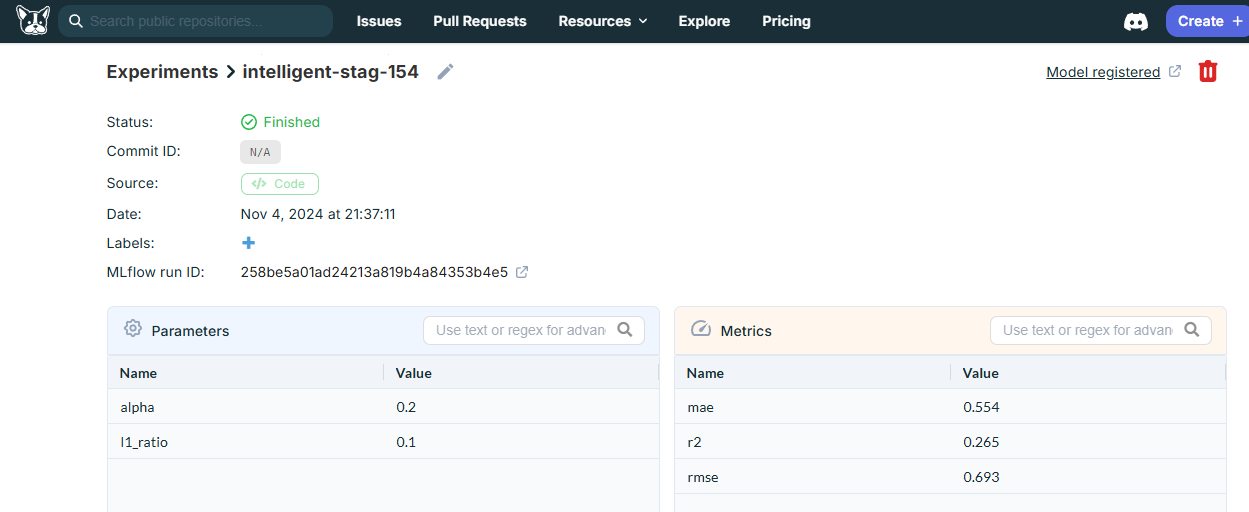

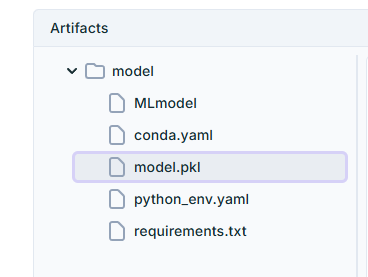

## Agora iremos converter para código modular

Começamos do passo 4 em diante(do workflow em notes.ipynb)

O código inteiro da seção `Creating the Dataclass` vai para `src/entity/config_entity.py`

O código inteiro da seção `Update the Config Manager` vai para `src/config/configuration.py`

O código inteiro da seção `Update the Components` vai para `src/components/nome_da_step.py`

O código inteiro da seção `Testing` vai para `src/pipeline/nome_da_step_pipeline.py`, com implementação OOP, ver exemplo 

O código anterior, vai para `main.py`, podendo chamar diretamente a classe, só ver o exemplo